In [1]:
from pathlib import Path
import random
import time
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('PyTorch device:', device)

PyTorch device: cpu


In [2]:
class MultiLabelVGG16(nn.Module):
    
    def __init__(self, n_class):
        super().__init__()
        self.vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        for param in self.vgg16.features.parameters():
            param.requires_grad = False
        in_features = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Sequential(
            nn.Linear(in_features, n_class),
            nn.Sigmoid()
        )
        self.epochs = 0

    def forward(self, x):
        return self.vgg16(x)


to_rgb = lambda x: x.convert('RGB')
mean = [0.485,0.456,0.406]
std = [0.229,0.224,0.225]
transform = transforms.Compose([
    to_rgb,
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,std=std),
])

In [3]:
model = torch.load('/kaggle/input/european-flood-2013/6/mlvgg16.022.pth',
                   weights_only=False,
                   map_location=device)
print(model)

MultiLabelVGG16(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
    

In [17]:
prefix = Path('../input/european-flood-2013')
path_data = [prefix / 'harz17_rhine18/harz17',
             prefix / 'harz17_rhine18/rhine18']

with open(prefix/'harz17.json') as f:
    dict_harz17 = json.load(f)
with open(prefix/'rhine18.json') as f:
    dict_rhine18 = json.load(f)


harz17 = []
for f in path_data[0].iterdir():
    if dict_harz17[f.stem]['RelDepth']:
        harz17.append((f,1))
    else:
        harz17.append((f,0))

rhine18 = []
for f in path_data[1].iterdir():
    if dict_rhine18[f.stem]['RelDepth']:
        rhine18.append((f,1))
    else:
        rhine18.append((f,0))

print(len(harz17))
print(len(rhine18))

533
1389


In [18]:
target_harz17 = [b for _,b in harz17]
target_rhine18 = [b for _,b in rhine18]
print(sum(target_harz17))
print(sum(target_rhine18))

142
298


In [19]:
class FloodDataset(Dataset):

    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.transform(Image.open(self.data[idx][0]))
        label = torch.tensor([self.data[idx][1]],dtype=torch.float32)
        return img, label


batch_size = 256
harz17_ds = FloodDataset(harz17, transform)
harz17_loader = DataLoader(harz17_ds,
                           batch_size=batch_size,
                           shuffle=False,
                           pin_memory=True,
                           num_workers=3)
rhine18_ds = FloodDataset(rhine18, transform)
rhine18_loader = DataLoader(rhine18_ds,
                           batch_size=batch_size,
                           shuffle=False,
                           pin_memory=True,
                           num_workers=3)

In [20]:
criterion = nn.BCELoss()

def model_eval(model, data_loader, criterion, dev):
    model.eval()
    model.to(dev)
    running_loss = 0.0
    r = []
    with torch.no_grad():
        for X, Y in data_loader:
            X = X.to(dev)
            Y = Y.to(dev)
            outputs = model(X)
            r.append(outputs)
            loss = criterion(outputs, Y)
            running_loss += loss.item()   
    return r, running_loss

In [21]:
results17,_ = model_eval(model, harz17_loader, criterion, device)
results18,_ = model_eval(model, rhine18_loader, criterion, device)

In [22]:
out_harz17 = torch.cat(results17,dim=0).squeeze(1)
out_rhine18 = torch.cat(results18,dim=0).squeeze(1)
if device == torch.device('cuda'):
    out_harz17 = out_harz17.cpu()
    out_rhine18 = out_rhine18.cpu()

In [23]:
from sklearn.metrics import average_precision_score
print(average_precision_score(target_harz17, out_harz17))
print(average_precision_score(target_rhine18, out_rhine18))

0.6254843562123729
0.6510692865431315


In [24]:
def get_prec_rec(target, out):
    precisions = []
    recalls = []
    pstep = np.linspace(0,1,200)
    for p in pstep:
        tp = 0
        fp = 0
        fn = 0
        for ta,ot in zip(target,out):
            if ta==0 and ot>p:
                fp += 1
            if ta==1 and ot>p:
                tp += 1
            if ta==1 and ot<p:
                fn += 1
        try:
            prec = tp/(fp+tp)
        except:
            prec = 1
        rec = tp/(tp+fn)
        precisions.append(prec)
        recalls.append(rec)
    return precisions, recalls


harz17_prec, harz17_rec = get_prec_rec(target_harz17,out_harz17)
rhine18_prec, rhine18_rec = get_prec_rec(target_rhine18,out_rhine18)

In [25]:
def best_possible_f1(prec,rec):
    f1 = []
    for p,r in zip(prec,rec):
        try:
            f1.append((2*p*r)/(p+r))
        except:
            pass
    return max(f1)


print(best_possible_f1(harz17_prec,harz17_rec))
print(best_possible_f1(rhine18_prec,rhine18_rec))

0.6261980830670927
0.6329113924050632


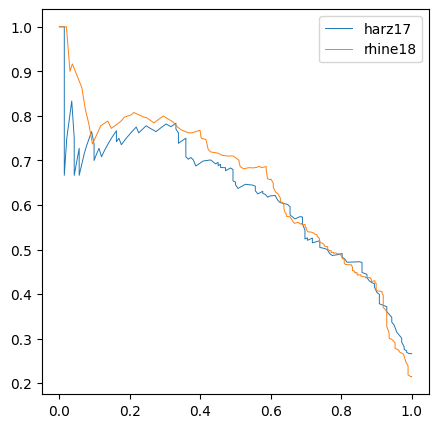

In [26]:
plt.figure(figsize=(5, 5))
plt.plot(harz17_rec,harz17_prec, linewidth=0.7, label='harz17')
plt.plot(rhine18_rec,rhine18_prec, linewidth=0.7, label='rhine18')
plt.legend();